## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

1. Oczyść dane i zaprezentuj rozkład klas

In [2]:
import pandas as pd
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

c:\Users\Administrator\Desktop\-NLP-Stress-Identification\StressEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('Stress.csv')
data

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005
...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [5]:
cols_to_drop = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df = data.drop(cols_to_drop,axis=1)
df.sample(5)

,text,label
612,I am so scared to go up to 10mg because I want...,1
1015,I can't even talk about the day she left me be...,1
1101,I was sexually abused when I was a kid and I s...,1
2655,(TW sexual abuse mentions) When I was 14 I was...,1
273,"I wouldn't say I'm a generally anxious person,...",0


In [6]:
df['label'].unique()

array([1, 0], dtype=int64)

In [7]:
df.groupby('label').nunique()

,text
label,
0,1338
1,1485


<AxesSubplot:xlabel='label', ylabel='count'>

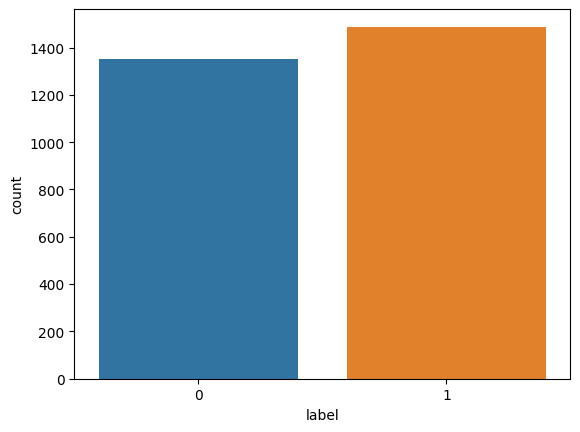

In [8]:
sns.countplot(x='label', data=df)

In [9]:
df['text'] = df['text'].apply(lambda x: x.lower())
df.sample(5)

,text,label
965,i obsess about this in my head 24/7 and even t...,1
2643,she talked sarcastically about how my life is ...,0
1234,i mentioned that i am unhappy with my nametag ...,0
2205,i was having a mild form of attack during the ...,0
2255,"so i guess i'll jump right in. i have ptsd, an...",0


In [10]:
re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
df['text'] = df['text'].apply(lambda x: re_url.sub('', x))

re_letter = re.compile(r"[^a-z\s']")
df['text'] = df['text'].apply(lambda x: re_letter.sub('', x))
df.sample(10)

,text,label
152,as for internet i pay mo on my phone for unlim...,0
2637,has anyone else had this sensation also if i c...,1
1138,because any potential new employer is always g...,1
1308,is this the way our state agencies treat the e...,1
2706,this kind of thing just makes me want to stop ...,1
2685,the reality is acceptance is a huge step in mo...,0
2458,but now i want that to change my need for paxi...,1
2110,i can't tell if that's me being a toxic person...,1
2054,i've stopped telling it and when someone at w...,1
2659,maybe programming i can spend more than hours...,0


In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_md

In [11]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [ ]:
nlp.Defaults.stop_words

In [12]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

df['text'] = df['text'].apply(remove_stopwords)
df.sample(10)

,text,label
1451,know grandmother wanted traditional having gra...,0
682,temper anger issues i'm seen maybe i'm cause a...,0
2631,posted story url it's literally long actually ...,1
578,need update texted forgot happened reminded sa...,0
1611,im frustrated dont know trust hand dreams poin...,1
1908,happy loving usual speaks father weekly basis ...,0
1962,etc etc etc brain takes little choice water bl...,1
655,result total burn months ago situation abuser ...,1
1078,change way i'm thinking understand shouldn't c...,0
1715,suffered years abusive relationship husband dr...,1


In [13]:
df.drop_duplicates(subset='text', keep='first', inplace=True)

In [14]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

df['text'] = df['text'].progress_apply(lemmatize)
df.sample(10)

100%|██████████| 2818/2818 [00:19<00:00, 144.74it/s]


,text,label
2588,I be try fill claim exemption come notice levy...,1
85,send extreme anxiety spiral I would see mother...,1
1894,dollar pocket graduate high school stay differ...,0
827,week problem solve realise anxious recently I ...,1
775,say do not want therapy know that s usual sugg...,0
2557,mistake result shake complain boss falsely amp...,1
1782,do not play know play nbsp weaponize mental he...,0
1198,dear reddit tell today rant man voice concerne...,1
866,fun fact help bit year ago twitter check tweet...,0
1764,break bf yrs sunday suspecting reason fall dep...,1


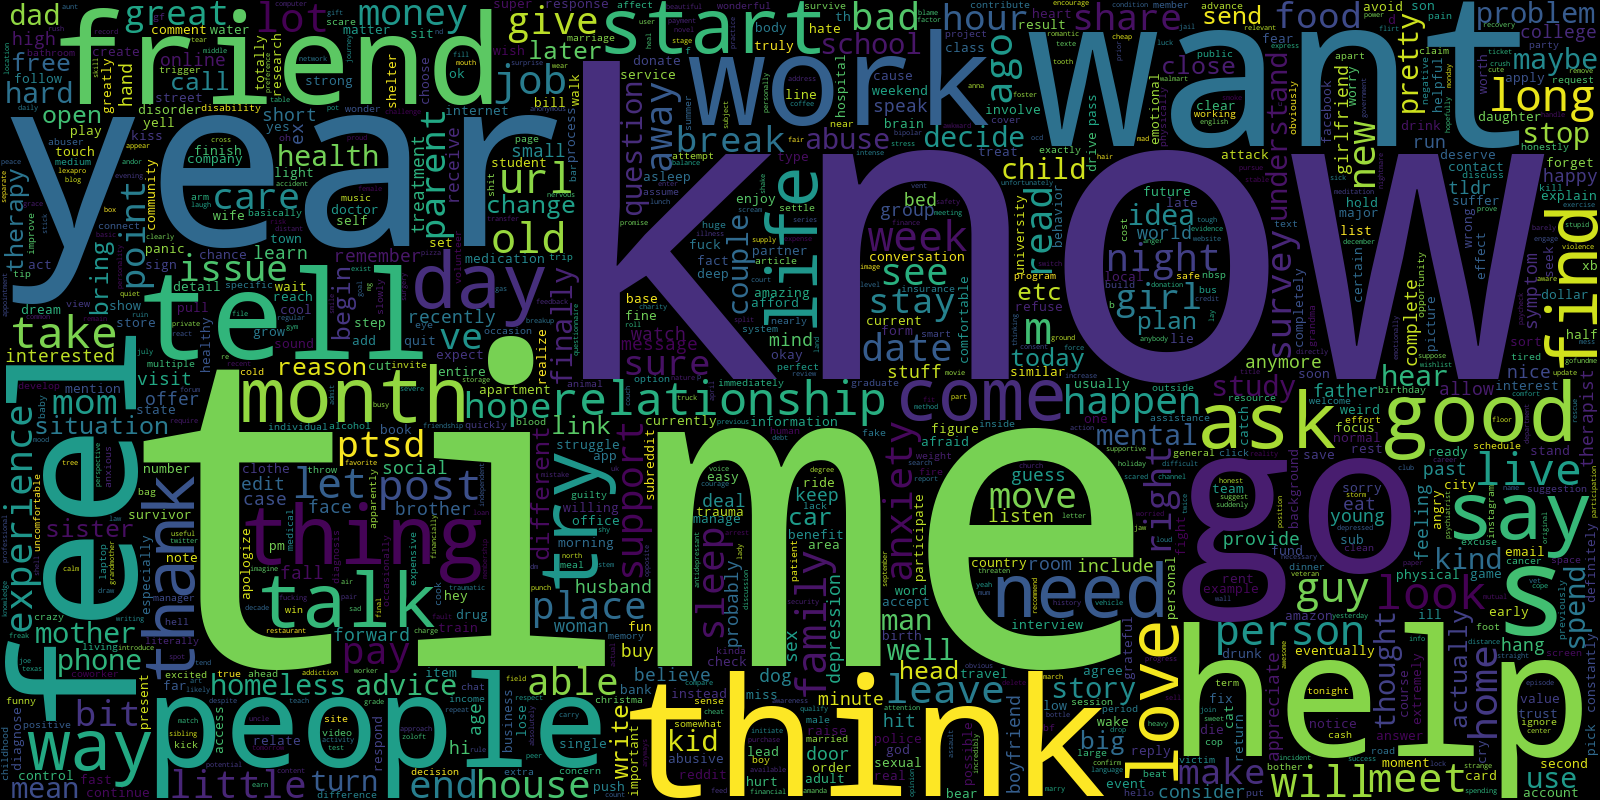

In [17]:
no_stress = ' '.join(df[df['label']==0]['text'])

wc_no_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(no_stress)
wc_no_stress.to_image()

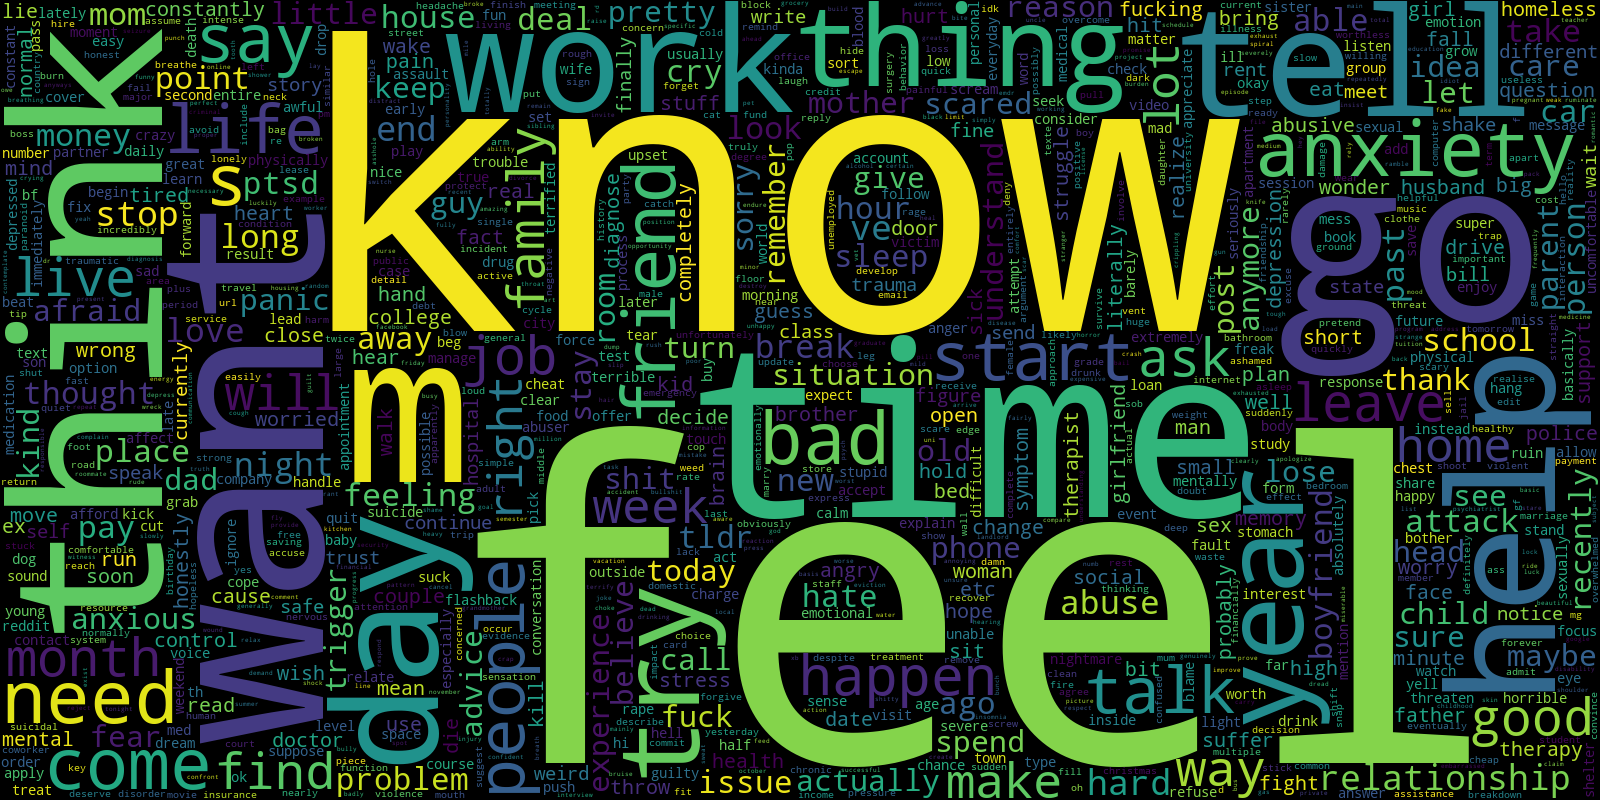

In [18]:
stress = ' '.join(df[df['label']==1]['text'])

wc_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(stress)
wc_stress.to_image()

2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN <---
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.1, random_state=42)

In [16]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_val_tokens = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(seq) for seq in X_train_tokens)

X_train_tokens = pad_sequences(X_train_tokens, maxlen=max_len, padding='post')
X_val_tokens = pad_sequences(X_val_tokens, maxlen=max_len, padding='post')


Sieć CNN

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D

embedding_dim = 50

model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model_2.add(Conv1D(128, 5, activation='relu'))
model_2.add(GlobalMaxPooling1D())
model_2.add(Dense(1, activation='sigmoid'))
print(model_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 143, 50)           429600    
                                                                 
 conv1d (Conv1D)             (None, 139, 128)          32128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 461,857
Trainable params: 461,857
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cnn = model_2.fit(X_train_tokens, y_train, epochs=3, validation_data=(X_val_tokens, y_val))

Epoch 1/3
80/80 [==============================] - 3s 20ms/step - loss: 0.6820 - accuracy: 0.5450 - val_loss: 0.6516 - val_accuracy: 0.6418
Epoch 2/3
80/80 [==============================] - 1s 16ms/step - loss: 0.5841 - accuracy: 0.7342 - val_loss: 0.5607 - val_accuracy: 0.6915
Epoch 3/3
80/80 [==============================] - 1s 16ms/step - loss: 0.4000 - accuracy: 0.8336 - val_loss: 0.5172 - val_accuracy: 0.7092


In [20]:
print(" Accuracy on Val data: ",model_2.evaluate(X_val_tokens,y_val)[1] *100 ,"%")

9/9 [==============================] - 0s 4ms/step - loss: 0.5172 - accuracy: 0.7092
 Accuracy on Val data:  70.92198729515076 %


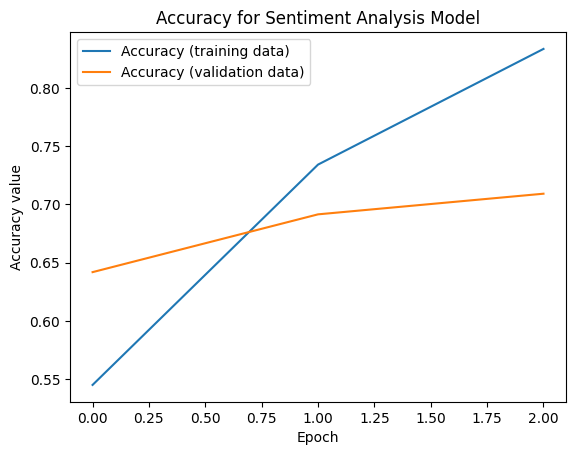

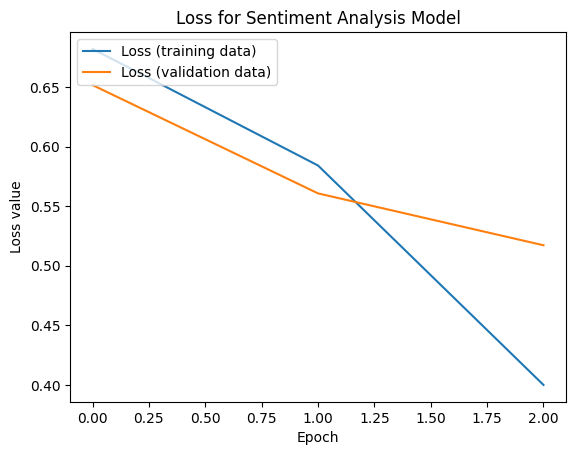

In [21]:
import matplotlib.pyplot as plt

plt.plot(model_cnn.history['accuracy'], label='Accuracy (training data)')
plt.plot(model_cnn.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Sentiment Analysis Model')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(model_cnn.history['loss'], label='Loss (training data)')
plt.plot(model_cnn.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Sentiment Analysis Model')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

In [27]:
def prepare_sentence(sentence):

    sentence = sentence.lower()

    re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
    sentence = re_url.sub('', sentence)

    re_letter = re.compile(r"[^a-z\s']")
    sentence = re_letter.sub('', sentence)

    def remove_stopwords(text):
        return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

    sentence = remove_stopwords(sentence)

    def lemmatize(text):
        return ' '.join([x.lemma_ for x in nlp(text)])

    sentence = lemmatize(sentence)

    tokenized_sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(tokenized_sentence, maxlen=max_len, padding='post')

    return sentence

In [28]:
def predict_sentiment(model, sentence):
    
    prepared_sentence = prepare_sentence(sentence)
    prediction = model.predict(prepared_sentence)

    if prediction >= 0.5:
        return "I can sense STRESS in this sentence"
    else:
        return "All good don't sense ANY STRESS in here "

Sieć CNN

In [29]:
sentence = "I had a peaceful evening reading my favorite book."
result = predict_sentiment(model_2, sentence)
print(result)

1/1 [==============================] - 0s 127ms/step
All good don't sense ANY STRESS in here 
